# 3.0 Cluster Analysis

**Tasks**: Based on the taxi trip patterns, can you identify clusters of trip types and/or customer types? How would you label these clusters? 

**Methods**: Identify clusters with soft-clustering and visualize your results. Compare your results to a hard-clustering method of your choice. You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data.
Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e., using Spatial Kernel Density Estimation)?

## Outline of this notebook:
1. Helper Functions
2. Adding Additional Features
3. Feature Selection
4. ...

In [1]:
# Hexagon resolution to work with for the rest of the notebook
RES = 8

In [63]:
# Standard libraries - run pip install if necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Geospatial libraries
from h3 import h3 
import geopandas as gp
import folium
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
## Color for map 
import branca
import branca.colormap as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

In [3]:
taxi_df = pd.read_csv("data/prepped/prep_taxidata.csv")

In [4]:
taxi_df.head(3)

,Unnamed: 0,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,...,pickup_area_number,dropoff_community,dropoff_area_number,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,payment_type_encoded,company_encoded,taxi_id_encoded
0,0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31 23:45:00,2023-01-01 00:15:00,2081.0,4.42,NaN,NaN,20.50,...,2,UPTOWN,3,872664d8effffff,872664d89ffffff,882664d8e1fffff,882664d897fffff,0,0,0
1,1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,13.84,...,8,WEST TOWN,24,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff,1,0,1
2,2,3f5cd3f78e5cab455606a31372a95d3204b2fb3f,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2022-12-31 23:45:00,2023-01-01 00:00:00,600.0,0.90,NaN,NaN,7.00,...,8,NEAR NORTH SIDE,8,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff,2,1,2


In [5]:
taxi_df.isna().sum()

Unnamed: 0                          0
trip_id                             0
taxi_id                             0
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           2884556
dropoff_census_tract          2884556
fare                                0
tips                                0
tolls                               0
extras                              0
trip_total                          0
payment_type                        0
company                             0
pickup_centroid_latitude            0
pickup_centroid_longitude           0
pickup_centroid_location            0
dropoff_centroid_latitude           0
dropoff_centroid_longitude          0
dropoff_centroid_location           0
trip_hours                          0
hour                                0
4_hour_window                       0
6_hour_window                       0
weekday     

In [6]:
pd.to_numeric(taxi_df["pickup_area_number"], downcast='integer')
pd.to_numeric(taxi_df["dropoff_area_number"], downcast='integer')

0           3
1          24
2           8
3           8
4           8
           ..
5320304    22
5320305    32
5320306    77
5320307     3
5320308     8
Name: dropoff_area_number, Length: 5320309, dtype: int8

In [7]:
taxi_df.dtypes

Unnamed: 0                      int64
trip_id                        object
taxi_id                        object
trip_start_timestamp           object
trip_end_timestamp             object
trip_seconds                  float64
trip_miles                    float64
pickup_census_tract           float64
dropoff_census_tract          float64
fare                          float64
tips                          float64
tolls                         float64
extras                        float64
trip_total                    float64
payment_type                   object
company                        object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
pickup_centroid_location       object
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dropoff_centroid_location      object
trip_hours                    float64
hour                            int64
4_hour_window                   int64
6_hour_window                   int64
weekday     

## 1.0 Helper functions

In [37]:
# Scaling
def scale_df(X):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(X)
    return pd.DataFrame(df_scaled, columns=X.columns, index=X.index)

In [76]:
# Finding optimal number of cluster

# Grid search
def minibatch_elbow_method(df_scaled ,max_clusters=10, batch_size=1000, random_state=42):
    loss = []
    for k in range(1, max_clusters+1):
        mbk = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=random_state, n_init="auto")
        mbk.fit(df_scaled)
        loss.append(mbk.inertia_)

    # Plot elbow curve
    plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey')
    plt.plot(range(1, max_clusters+1), loss, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Loss')
    plt.title('Elbow Method with Mini-Batch K-Means')
    plt.show()
    
# Silhouette score
def minibatch_silhouette_score(df_scaled, max_clusters=10, batch_size=1000, random_state=42, sample_size=10000): 
    silhouette_scores = []
    for k in range(2, max_clusters+1):
        mbk = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=random_state, n_init="auto")
        cluster_labels = mbk.fit_predict(df_scaled)
        score = silhouette_score(df_scaled, cluster_labels, sample_size=sample_size)
        silhouette_scores.append(score)

    # Plot scores
    plt.grid(True, linestyle='--', alpha=0.7, color='lightgrey')
    plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    plt.show()

In [9]:
# Feature Selection
def feature_selection_kmeans(df, maxvars=3, kmin=2, kmax=8, cut_off=0.5, random_state=1984):
    """
    Perform feature selection using K-means clustering and silhouette score.
    Returns a tuple of the list of selected feature names, the optimal number of clusters and the cluster assignment itself
    """
    kmeans_kwargs = {
        "init": "random",
        "n_init": 20,
        "max_iter": 1000,
        "random_state": random_state
    }

    cols = list(df.columns)
    results_for_each_k = []
    vars_for_each_k = {}

    for k in range(kmin, kmax + 1):
        selected_variables = []
        while len(selected_variables) < maxvars:
            results = []
            for col in cols:
                scols = selected_variables + [col]
                kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
                kmeans.fit(df[scols])
                results.append(silhouette_score(df[scols], kmeans.predict(df[scols])))
            
            selected_var = cols[np.argmax(results)]
            selected_variables.append(selected_var)
            cols.remove(selected_var)
        
        results_for_each_k.append(max(results))
        vars_for_each_k[k] = selected_variables

    best_k = np.argmax(results_for_each_k) + kmin
    selected_variables = vars_for_each_k[best_k]

    kmeans = KMeans(n_clusters=best_k, **kmeans_kwargs)
    kmeans.fit(df[selected_variables])
    clusters = kmeans.predict(df[selected_variables])

    return selected_variables, best_k, clusters

## 2.0 Adding Additional Features 
You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data.

### 2.0.1 Distance to city center

In [10]:
# City center = hexagon with the most pickups
center_hex = taxi_df[f'h3_res{RES}_pickup'].value_counts().idxmax()

print(f'Center hexagon: {center_hex}')
taxi_df[taxi_df[f'h3_res{RES}_pickup'] == center_hex].iloc[0].pickup_community

Center hexagon: 882664c1edfffff


'NEAR NORTH SIDE'

In [11]:
# Calculate grid distances
def calculate_h3_grid_distances(df, center_hex):
    def h3_grid_distance(h1, h2):
            return h3.h3_distance(h1, h2)

    df[f'dist_from_center_pickup'] = df[f'h3_res{RES}_pickup'].apply(lambda x: h3_grid_distance(x, center_hex))
    df[f'dist_from_center_dropoff'] = df[f'h3_res{RES}_dropoff'].apply(lambda x: h3_grid_distance(x, center_hex))
    
    return df

In [12]:
taxi_df = calculate_h3_grid_distances(taxi_df, center_hex)

### 2.0.2 Trip Direction

In [13]:
# Get the direction of the trip
## If moving_towards_center + -> moving towards city center // If moving_towards_center - -> moving away from city center
taxi_df['moving_towards_center'] = taxi_df['dist_from_center_pickup'] - taxi_df['dist_from_center_dropoff'] 

In [14]:
taxi_df[taxi_df['moving_towards_center'] < 0].head(3)

,Unnamed: 0,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,...,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,payment_type_encoded,company_encoded,taxi_id_encoded,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center
1,1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,13.84,...,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff,1,0,1,0,4,-4
6,6,32c54ad25f76c07b29bc59b04f9f196cf811ed67,cb1a522e6e968cbebb7ce23e6775a4769de4aeb2154fa5...,2022-12-31 23:45:00,2023-01-01 00:00:00,876.0,8.91,NaN,NaN,23.75,...,872664c1bffffff,872664cd8ffffff,882664c1b5fffff,882664cd89fffff,0,0,6,6,23,-17
7,8,3186be22cdd5d17def50e44eca6be9ec9b0a9974,4f78222d267c08ee7267810e5f3f2241dc61bf1396d036...,2022-12-31 23:45:00,2022-12-31 23:45:00,540.0,0.70,1.703108e+10,1.703184e+10,7.25,...,872664c1effffff,872664c1affffff,882664c1e7fffff,882664c1a9fffff,3,4,7,2,3,-1


In [15]:
taxi_df.columns

Index(['Unnamed: 0', 'trip_id', 'taxi_id', 'trip_start_timestamp',
       'trip_end_timestamp', 'trip_seconds', 'trip_miles',
       'pickup_census_tract', 'dropoff_census_tract', 'fare', 'tips', 'tolls',
       'extras', 'trip_total', 'payment_type', 'company',
       'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_centroid_location', 'dropoff_centroid_latitude',
       'dropoff_centroid_longitude', 'dropoff_centroid_location', 'trip_hours',
       'hour', '4_hour_window', '6_hour_window', 'weekday', 'month',
       'pickup_community', 'pickup_area_number', 'dropoff_community',
       'dropoff_area_number', 'h3_res7_pickup', 'h3_res7_dropoff',
       'h3_res8_pickup', 'h3_res8_dropoff', 'payment_type_encoded',
       'company_encoded', 'taxi_id_encoded', 'dist_from_center_pickup',
       'dist_from_center_dropoff', 'moving_towards_center'],
      dtype='object')

In [16]:
# Get weekday or not (0 if not, 1 if it is)
taxi_df['is_weekday'] = taxi_df['weekday'].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]).astype(int)

# Analyze weekday impact
weekday_impact = taxi_df.groupby('is_weekday')[['trip_miles', 'trip_seconds', 'trip_total', 'dist_from_center_pickup']].mean()
print("Weekday Impact:")
print(weekday_impact)
taxi_df.head()

Weekday Impact:
            trip_miles  trip_seconds  trip_total  dist_from_center_pickup
is_weekday                                                               
0             5.497319    1049.49831   23.697390                 8.662318
1             5.330449    1111.13201   22.736041                 8.464165


,Unnamed: 0,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,...,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,payment_type_encoded,company_encoded,taxi_id_encoded,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center,is_weekday
0,0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31 23:45:00,2023-01-01 00:15:00,2081.0,4.42,NaN,NaN,20.50,...,872664d89ffffff,882664d8e1fffff,882664d897fffff,0,0,0,13,8,5,0
1,1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,13.84,...,872664cacffffff,882664c1edfffff,882664cac3fffff,1,0,1,0,4,-4,0
2,2,3f5cd3f78e5cab455606a31372a95d3204b2fb3f,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2022-12-31 23:45:00,2023-01-01 00:00:00,600.0,0.90,NaN,NaN,7.00,...,872664c1effffff,882664c1edfffff,882664c1edfffff,2,1,2,0,0,0,0
3,3,38292159642750da7b20419330566f9eb0961cde,81092e4881f56106fae845c3ae4492f8b3c3213c33c920...,2022-12-31 23:45:00,2023-01-01 00:00:00,546.0,0.85,NaN,NaN,6.50,...,872664c1effffff,882664c1edfffff,882664c1edfffff,3,2,3,0,0,0,0
4,4,3e01498f8ff771ad7eb37e4844cef20201b6c339,4ae32e2eb244ce143800e0c40055e537cc50e3358a07ce...,2022-12-31 23:45:00,2023-01-01 00:00:00,574.0,0.33,NaN,NaN,6.25,...,872664c1effffff,882664c1edfffff,882664c1edfffff,3,3,4,0,0,0,0


### 2.0.3 Drop redundant columns

Now we want to drop any columns that are trivial to the clustering process, since either the columns are available in another form, or they are not analysed at all. For instance, columns trid_id, company and payment_type have now a respective encoded column, the trip start time has been discretized into more granular columns and the end time is not analysed. 
Furthermore, columns for geographical information can be dropped too as we have corresponding h3 columns that summarize most important information. 

In [17]:
# Drop unneeded columns for further steps 
columns_to_drop = ['Unnamed: 0','trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_centroid_location', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'dropoff_centroid_location',]
prep_df = taxi_df.drop(columns_to_drop, axis=1)
prep_df.head()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,tolls,extras,trip_total,trip_hours,...,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,payment_type_encoded,company_encoded,taxi_id_encoded,dist_from_center_pickup,dist_from_center_dropoff,moving_towards_center,is_weekday
0,2081.0,4.42,NaN,NaN,20.50,0.00,0.0,0.0,20.50,0.578056,...,872664d89ffffff,882664d8e1fffff,882664d897fffff,0,0,0,13,8,5,0
1,812.0,0.00,NaN,NaN,13.84,2.73,0.0,0.0,16.57,0.225556,...,872664cacffffff,882664c1edfffff,882664cac3fffff,1,0,1,0,4,-4,0
2,600.0,0.90,NaN,NaN,7.00,2.00,0.0,3.0,12.00,0.166667,...,872664c1effffff,882664c1edfffff,882664c1edfffff,2,1,2,0,0,0,0
3,546.0,0.85,NaN,NaN,6.50,0.00,0.0,0.0,6.50,0.151667,...,872664c1effffff,882664c1edfffff,882664c1edfffff,3,2,3,0,0,0,0
4,574.0,0.33,NaN,NaN,6.25,0.00,0.0,0.0,6.25,0.159444,...,872664c1effffff,882664c1edfffff,882664c1edfffff,3,3,4,0,0,0,0


## 3.0 Weather Data

In [18]:
weather_df = pd.read_csv("data/prepped/weather_taxi_merged_df.csv")
weather_df.shape

(5320309, 51)

In [19]:
weather_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'trip_id', 'taxi_id',
       'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds',
       'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'fare',
       'tips', 'tolls', 'extras', 'trip_total', 'payment_type', 'company',
       'pickup_centroid_latitude', 'pickup_centroid_longitude',
       'pickup_centroid_location', 'dropoff_centroid_latitude',
       'dropoff_centroid_longitude', 'dropoff_centroid_location', 'trip_hours',
       'hour', '4_hour_window', '6_hour_window', 'weekday', 'month',
       'pickup_community', 'pickup_area_number', 'dropoff_community',
       'dropoff_area_number', 'h3_res7_pickup', 'h3_res7_dropoff',
       'h3_res8_pickup', 'h3_res8_dropoff', 'payment_type_encoded',
       'company_encoded', 'taxi_id_encoded', 'Date', 'Time', 'Temperature',
       'Dew Point', 'Humidity', 'Wind', 'Wind Speed', 'Wind Gust', 'Pressure',
       'Precip.', 'Condition'],
      dtype='object')

In [20]:
# Drop columns
columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'trip_id', 'taxi_id',
                   'trip_start_timestamp', 'trip_end_timestamp', 'payment_type', 'company', 'pickup_centroid_latitude', 'pickup_centroid_longitude',
                   'pickup_centroid_location', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'dropoff_centroid_location',
                   # Weather cols to drop
                  'Date', 'Time', 'Dew Point', 'Wind', 'Wind Speed', 'Wind Gust', 'Pressure',
                  ]
weather_df_prep = weather_df.drop(columns_to_drop, axis=1)
weather_df_prep.head(3)

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,tolls,extras,trip_total,trip_hours,...,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,payment_type_encoded,company_encoded,taxi_id_encoded,Temperature,Humidity,Precip.,Condition
0,501.0,0.65,NaN,NaN,6.25,0.0,0.0,2.0,8.25,0.139167,...,872664c1effffff,882664c1edfffff,882664c1edfffff,3,5,1991,31°F,85°%,0.0°in,Light Snow / Windy
1,180.0,0.50,1.703108e+10,1.703108e+10,4.50,0.0,0.0,0.0,4.50,0.050000,...,872664c1effffff,882664c1e1fffff,882664c1ebfffff,3,4,78,31°F,85°%,0.0°in,Light Snow / Windy
2,649.0,5.08,NaN,NaN,15.25,0.0,0.0,0.0,15.25,0.180278,...,872664ca1ffffff,882664c1edfffff,882664ca11fffff,3,3,804,31°F,85°%,0.0°in,Light Snow / Windy


## 4.0 POI Data

In [21]:
poi_df = pd.read_csv("data/prepped/poi_df.csv")
poi_df.head()

,osmid,amenity,name,geometry,public_transport,latitude,longitude,count,h3_res7,h3_res8,poly_res7,poly_res8,poi_density_res7,poi_density_res8,category
0,20217109,ferry_terminal,Shoreline Sightseeing,POINT (-87.6225172 41.8891445),station,41.889145,-87.622517,45,872664c1effffff,882664c1e3fffff,POLYGON ((-87.63048927308355 41.90755371098675...,POLYGON ((-87.62100146715468 41.89255291202126...,1621,328,Transportation
1,20217442,ferry_terminal,Union Station/Willis Tower - Shoreline Water T...,POINT (-87.6377402 41.8790618),station,41.879062,-87.637740,45,872664c1affffff,882664c1adfffff,POLYGON ((-87.63912440648137 41.88713767856642...,POLYGON ((-87.63912440648137 41.88713767856642...,1822,417,Transportation
2,269449042,parking_entrance,NaN,POINT (-87.6150579 41.8586894),NaN,41.858689,-87.615058,10,872664c1bffffff,882664c1b1fffff,"POLYGON ((-87.61820944356228 41.8710984903598,...",POLYGON ((-87.61347038938916 41.86360034164272...,349,36,Transportation
3,269450074,parking_entrance,NaN,POINT (-87.5841968 41.7917424),NaN,41.791742,-87.584197,10,872664cc5ffffff,882664cc59fffff,POLYGON ((-87.5937067068291 41.798228672497444...,POLYGON ((-87.58229602405846 41.79718226760902...,385,47,Transportation
4,269450344,parking_entrance,NaN,POINT (-87.6119452 41.8496767),NaN,41.849677,-87.611945,10,872664c1bffffff,882664c1b3fffff,"POLYGON ((-87.61820944356228 41.8710984903598,...",POLYGON ((-87.60873281770539 41.85610258554422...,349,26,Transportation


In [22]:
columns_to_keep = [f'h3_res{RES}', 'category']
poi_df_cluster = poi_df[columns_to_keep].copy()

# Step 2: One-hot encode the categories
poi_df_cluster = pd.get_dummies(poi_df_cluster, columns=['category'], prefix='', prefix_sep='')

# Step 3: Group by H3 index and sum the one-hot encoded categories
poi_df_cluster = poi_df_cluster.groupby(f'h3_res{RES}').sum().reset_index()
poi_df_cluster.head()

,h3_res8,Accommodation,Animal Services,Education,Financial Services,Food and Drink,Healthcare,Miscellaneous,Personal Care,Public Services,Recreation and Entertainment,Religious and Community,Shopping and Retail,Sports and Fitness,Transportation,Utilities
0,8826641903fffff,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0
1,8826641907fffff,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,8826641909fffff,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,882664190bfffff,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0
4,882664190dfffff,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## 5.0 Clustering

We cluster using a combination of k-means++ to find a suitable amount of clusters and then pick Gaussian Mixture Model. Clusters are formed for the dfs:
1. Trips
2. Trip + Weather
3. Trip Hexagon + POI

prep_df, poi_df_cluster, weather_df_prep

#### 5.0.1 Trip

In [24]:
prep_df.columns

Index(['trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'fare', 'tips', 'tolls', 'extras', 'trip_total',
       'trip_hours', 'hour', '4_hour_window', '6_hour_window', 'weekday',
       'month', 'pickup_community', 'pickup_area_number', 'dropoff_community',
       'dropoff_area_number', 'h3_res7_pickup', 'h3_res7_dropoff',
       'h3_res8_pickup', 'h3_res8_dropoff', 'payment_type_encoded',
       'company_encoded', 'taxi_id_encoded', 'dist_from_center_pickup',
       'dist_from_center_dropoff', 'moving_towards_center', 'is_weekday'],
      dtype='object')

In [ ]:
numerical_features = ['trip_seconds',  'dist_from_center_pickup','dist_from_center_dropoff', 'moving_towards_center', 'is_weekday']
df_numerical = prep_df[numerical_features]
df_scaled = scale_df(df_numerical)
df_scaled.head()

We use Mini-Batch KMeans for faster and more efficient calculations, since our dataset is quite big (https://medium.com/@tanvirhossen_29772/mini-batch-k-means-e3083cc765f5). 

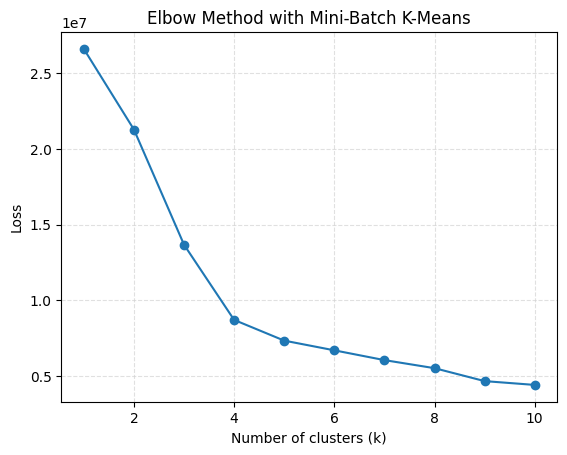

In [71]:
minibatch_elbow_method(df_scaled, max_clusters=10)

Based on the elbow method, we can determine that a number of 4 clusters seems most optimal for our clustering task. 

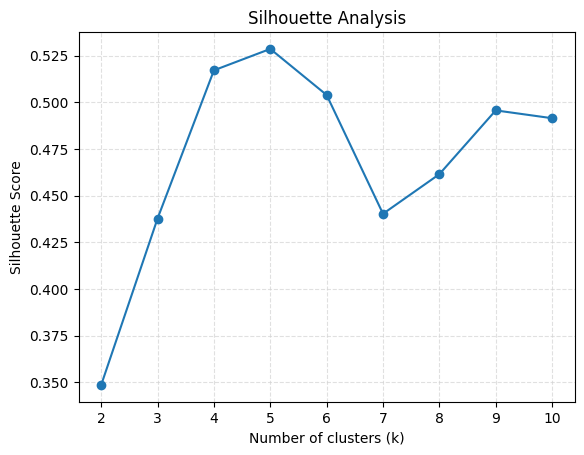

In [77]:
minibatch_silhouette_score(df_scaled, max_clusters=10, sample_size=10000)

Silhouette Score measures goodness of fit for different cluster numbers by (b-a)/max(a,b) where:
- b: average distance between all clusters
- a: average distance between each point within a cluster

The score is between [-1, 1], where
- -1 means clusters are assigned wrong
- 1 means clusters are well apart 
- 0 means cluster distance is not significant

(https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

We see from this visualization that we might want to increase our cluster number by 1 to 5 clusters, as this returns a higher score.